# Network processing

## 0. Data preprocessing

### 0.0. Import packages

In [47]:
from formation_codes_np import get_codes_pos_nos, DATA_FOLDER
import numpy as np
import networkx as nx
import os

### 0.1. Load the data

In [48]:


threshold_value = 150

team_id = 1

data, team_np = get_codes_pos_nos(threshold=threshold_value, t=team_id)

codes = data["codes"]
alive = team_np["alive"]
keyframes = team_np["keyframes"] - team_np["keyframes"][0]
phases = team_np["phases"]



### 0.2. Create data structures

We then convert the codes into ids to facilitate the elaboration.
 - `l` is the number of frames
 - `str_codes_all` contains all the codes for each frame converted to strings
 - `str_codes_set` and `str_codes` contains the unique codes
 - `codes_ids` contains the corresponding code id for each frame, which is the index of the `str_codes` list

 
From this, we construct a simple edge datastructure:
 - `edges_tstamps`  is a list of tuples containing which describe edges between the timestamps
 - `edges_ids` is a list of tuples containing which describe edges between the formation codes (at this point they all have length 1 time unit)
 - `non_self` is a boolean mask indicating edges which aren't loops (at this point can only be of size 1 time unit)
 - `edges_weights` is a list wich represents the edges' lengths in time units (at this point they all get assigned 1)
 - `edges_dead` is a mask wich represents the edges corresponding to transitions while the ball wasn't in play

In [49]:
l = len(codes)
str_codes_all = ["".join([str(c) for c in cs]) for cs in codes]
str_codes_set = set(str_codes_all)
str_codes = sorted(list(str_codes_set))
tstamps = keyframes[alive]

codes_ids = np.zeros(keyframes[-1], dtype=np.int32) - 1
codes_ids_alive = np.array([str_codes.index(sc) for sc in str_codes_all])
codes_ids[tstamps] = codes_ids_alive

edges_tstamps =  np.stack([tstamps[:-1], tstamps[1:]], axis=1)
edges_ids = codes_ids[edges_tstamps]
edges_weights = np.diff(edges_tstamps, axis=1).ravel()
edges_dead = edges_weights > 1


The following plot is an example of how the initial part of the network currently looks like. Edge thickness indicate the weight (currently all edges have weight $1$, except for dead edges), and the label indicate their order in time. Green edges indicate a formation's change occured while the game was alive, while red ones indicate a formation's change occured while the ball wasn't in play. 

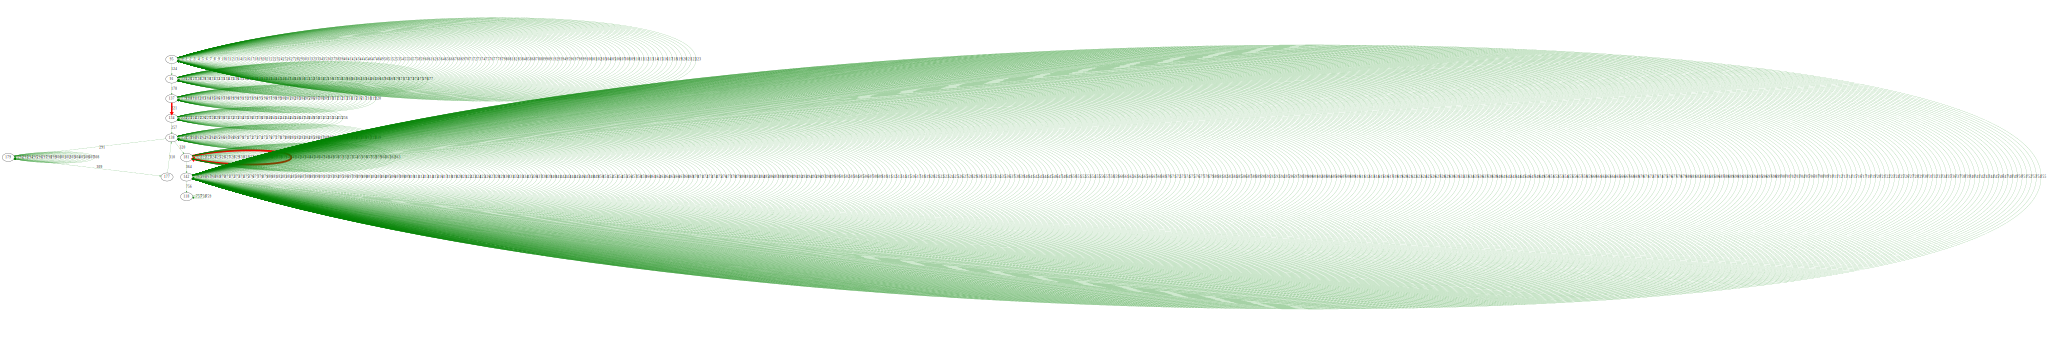

In [50]:
loops = edges_ids[:,0] == edges_ids[:,1]
plot_tstamp_end =  edges_tstamps[np.flatnonzero(~loops)[10],0]

def plot_net(et,ei,ew,ed,pts=0, pte=plot_tstamp_end,plot_all=False, thickness_function = lambda x: np.sqrt(x)/2):
    i_s, i_e = None, None
    
    if not plot_all:
        i_s = np.argmax(et[:,0] >= pts)
        i_e = np.argmax(et[:,0] >= pte)


    edges_sample = ei[i_s:i_e]
    edges_sample_weights = ew[i_s:i_e]
    edges_sample_dead = ed[i_s:i_e]

    edges_flat = np.append(edges_sample[:,0],edges_sample[-1,1])
    nodes_sample, nodes_ixs = np.unique(edges_flat, return_index=True)


    net = nx.MultiDiGraph()
    net.add_nodes_from(nodes_sample)
    for k, (e, w, d) in enumerate(zip(edges_sample, edges_sample_weights, edges_sample_dead)):
        net.add_edge(*e,label=k,penwidth=thickness_function(w), color="red" if d else "green")
    # net.graph['graph'] = {'scale': '5'}

    A = nx.drawing.nx_agraph.to_agraph(net)
    edge_attrs = {'arrowsize': '0.6', 'splines': 'curved'}
    for k, v in edge_attrs.items():
        A.edge_attr[k] = v
    A.layout('dot')
    return A

plot_net(edges_tstamps,edges_ids,edges_weights, edges_dead)


## 1. Merge loops

Merge the edges which loops multiple time on the same code, then update the corrisponding weights accordingly. 

In [51]:
def printdiff(msg, a, b):
    print(f"{msg}:", a,"-",a - b,"=",b)



def collapse_edges(et, ed, mask, ci=codes_ids):
    starts = np.flatnonzero(np.diff(mask.astype(np.int8)) == 1) + 1
    last_tstamp=edges_tstamps[-1,1]
    to_remove = np.copy(mask)
    # We keep the first edge and remove all the following ones
    to_remove[starts] = False
    to_remove[0] = False
    to_remove[ed] = False

    et_ = np.delete(et, to_remove, axis=0)
    ed_ = np.delete(ed, to_remove, axis=0)

    # We update all v, where e = (u,v), and the weights and ids
    et_[:-1,1] = et_[1:,0]
    assert last_tstamp > et_[-1,0]
    et_[-1,1] = last_tstamp
    ew_ = np.diff(et_, axis=1).ravel()
    ei_ = ci[et_]
    printdiff("New number of edges", len(et), len(et_))
    assert ew_.sum() == last_tstamp
    return et_, ei_, ew_, ed_

loops = edges_ids[:,0] == edges_ids[:,1]
edges_tstamps, edges_ids, edges_weights, edges_dead = collapse_edges(edges_tstamps, edges_dead, loops)

print("number of dead edges",edges_dead.sum(),"vs. total number of edges", len(edges_dead),"({:%})".format(np.average(edges_dead.astype(np.float64))))


New number of edges: 112580 - 103770 = 8810
number of dead edges 143 vs. total number of edges 8810 (1.623156%)


The network is now simplified and here it is how it looks for the first part.

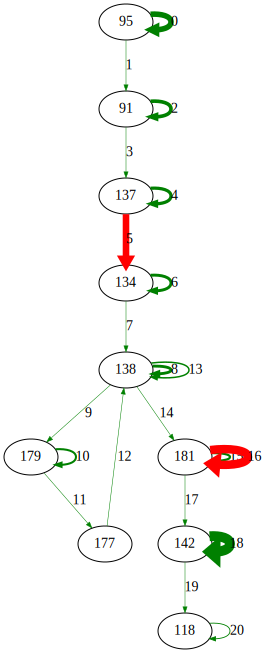

In [52]:
plot_net(edges_tstamps, edges_ids, edges_weights, edges_dead)

# 2. Removal of loops

In order to further simplify the network, we replace by short loops longer edges, i.e. a team keeping the same formation for a small period of time can be ignored and considered as a longer transition (in time) from the previous to the next formation.




For statistical and implementation reasons, we add a loop of size $0$ between two consecutive edge which are not loops.

In [53]:
insert_indices = ~(edges_ids[:, 0] == edges_ids[:, 1])



diff = np.diff(insert_indices.astype(np.int8))
consec_edges_end = np.flatnonzero(diff == 1) + 1
insert_indices[consec_edges_end] = False
insert_indices = np.flatnonzero(insert_indices)


values = edges_tstamps[insert_indices,0]
values = np.stack((values, values), axis=1)

edges_tstamps = np.insert(edges_tstamps,insert_indices, values, axis=0)
edges_dead = np.insert(edges_dead,insert_indices, False, axis=0)
edges_ids = codes_ids[edges_tstamps]
edges_weights = np.diff(edges_tstamps, axis=1).ravel()


The node with code 177 now have a loop of size 0.

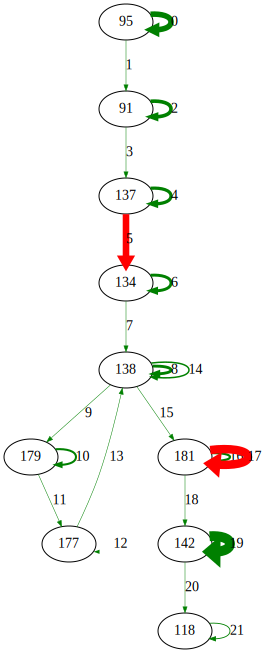

In [54]:
plot_net(edges_tstamps, edges_ids, edges_weights, edges_dead)

We set an arbitrary threshold (see `test_loop_t.ipynb`) for removing loops smaller than the threshold value.

In [55]:
is_loop = edges_ids[:,0] == edges_ids[:,1]
threshold = 100
remove_loops = np.zeros_like(is_loop)
remove_loops[is_loop] = edges_weights[is_loop] <= threshold

## 3. Update the network
### 3.1. Update by results obtained in step 2
We union the loops, invalid and circuits masks to remove the correct edges and replace them by longer ones.

In [56]:
tstart = edges_tstamps[:,0]
tend = edges_tstamps[:,1]


edges_to_replace = np.zeros_like(edges_weights,dtype=bool)

for i in np.flatnonzero(remove_loops):
    edges_to_replace[i-1:i+2] = True # Edges to and from the loop have to be replaced too

undetected_invalid = (~edges_to_replace) & (~edges_dead)

printdiff("Edges to replace",len(edges_to_replace), edges_to_replace.sum())

    

Edges to replace: 9301 - 182 = 9119


In [57]:
edges_tstamps, edges_ids, edges_weights, edges_dead = collapse_edges(edges_tstamps, edges_dead, edges_to_replace)
edges_to_replace[:]= False

New number of edges: 9301 - 8834 = 467


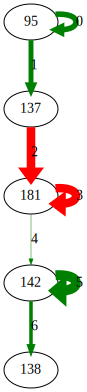

In [58]:
plot_net(edges_tstamps, edges_ids, edges_weights, edges_dead)

### 3.2. Merge successive loops

As we can see by the following example, we can have multiple loops that follow one another

[7687 7833]


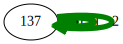

In [59]:


is_loop = edges_ids[:,0] == edges_ids[:,1]

multiple_loops = np.flatnonzero(is_loop[:-1] & is_loop[1:] & (edges_ids[1:,0] == edges_ids[:-1,1]))

print(edges_tstamps[multiple_loops[1]])

plot_tstamp_start = 7687
plot_tstamp_end = 8000
plot_net(edges_tstamps, edges_ids, edges_weights,edges_dead,pts=plot_tstamp_start,pte=plot_tstamp_end)

We can therefore merge them in a single loop.

New number of edges: 467 - 42 = 425


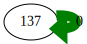

In [60]:
loops = edges_ids[:,0] == edges_ids[:,1]

edges_tstamps, edges_ids, edges_weights, edges_dead = collapse_edges(edges_tstamps, edges_dead, loops)
plot_net(edges_tstamps, edges_ids,  edges_weights, edges_dead, pts=plot_tstamp_start,pte=plot_tstamp_end)


## 4. Export final network

In [61]:
unique_cids = np.unique(np.append(edges_ids[:,0],edges_ids[-1,1]))

printdiff("Number of codes (nodes) in the network",len(str_codes),len(unique_cids))

Number of codes (nodes) in the network: 230 - 163 = 67


In [62]:

nodes = []


for id in unique_cids:
    nodes.append((id, {"code": str_codes[id]}))

N = nx.MultiDiGraph()
N.add_nodes_from(nodes)
for i, e in enumerate(edges_ids):
    N.add_edge(*e, weight=edges_weights[i], start_frame=edges_tstamps[i,0], end_frame=edges_tstamps[i,1])
print(N)
graph_filename = os.path.join(DATA_FOLDER, f"network_t{threshold_value}_processed.graphml")
nx.write_graphml_lxml(N, graph_filename)

MultiDiGraph with 67 nodes and 425 edges
